# Practical 5: Study of Optimizers

### 5A. Create a generic feedforward neural in which design stochastic gradient descent optimizer.


In [2]:
# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_cache = np.zeros_like(self.weights)
        self.bias_cache = np.zeros_like(self.biases)
        self.weight_momentums = np.zeros_like(self.weights)
        self.bias_momentums = np.zeros_like(self.biases)

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


### Activation function

### Relu activation function

- The relu activation function is used to introduce non-linearity in the neural network.
- The relu activation function is defined as follows:

$$ f(x) = max(0,x) $$



In [3]:
# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

### Softmax activation function

- The softmax activation function is used to normalize the output of the neural network.
- The softmax activation function is defined as follows:

$$ f(x) = \frac{e^x}{\sum_{i=1}^{n}e^x} $$

In [4]:
# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


### Optimizer

### SGD (Stochastic Gradient Descent)

- The SGD optimizer is used to update the weights of the neural network.
- The SGD optimizer is defined as follows:

$$ w = w - \alpha \frac{\partial L}{\partial w} $$

where,  
$w$ is the weight of the neural network, <br>
$\alpha$ is the learning rate<br>
$L$ is the loss function<br>

In [5]:
# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates


    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

### Adam optimizer

- The Adam optimizer is used to update the weights of the neural network.
- The Adam optimizer is defined as follows:

$$ m = \beta_1 m + (1 - \beta_1) \frac{\partial L}{\partial w} $$
$$ v = \beta_2 v + (1 - \beta_2) (\frac{\partial L}{\partial w})^2 $$
$$ w = w - \alpha \frac{m}{\sqrt{v} + \epsilon} $$

where,
$m$ is the first moment of the gradient<br>
$v$ is the second moment of the gradient<br>
$\beta_1$ is the exponential decay rate for the first moment estimates<br>
$\beta_2$ is the exponential decay rate for the second moment estimates<br>
$\alpha$ is the learning rate<br>
$\epsilon$ is a small constant to avoid division by zero<br>
$L$ is the loss function<br>


In [6]:
# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2

        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



## Adagrad Optimizers 

- The Adagrad optimizer is used to update the weights of the neural network.
- The Adagrad optimizer is defined as follows:

$$ v = v + (\frac{\partial L}{\partial w})^2 $$
$$ w = w - \alpha \frac{1}{\sqrt{v} + \epsilon} \frac{\partial L}{\partial w} $$

where,
$v$ is the sum of the squares of the gradients<br>
$\alpha$ is the learning rate<br>
$\epsilon$ is a small constant to avoid division by zero<br>
$L$ is the loss function<br>


In [7]:
class Optimizer_Adagrad:
    def __init__(self, learning_rate=0.01, decay=0.0, epsilon=1e-7):
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.iterations = 0
        self.cache = {}

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.current_learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        weight_gradients = layer.dweights
        bias_gradients = layer.dbiases

        # Update cache with squares of gradients
        self.cache.setdefault(layer, {})
        self.cache[layer]['weight'] = self.cache[layer].get('weight', 0.0) + np.square(weight_gradients)
        self.cache[layer]['bias'] = self.cache[layer].get('bias', 0.0) + np.square(bias_gradients)

        # Compute update
        weight_updates = - self.current_learning_rate * (weight_gradients / (np.sqrt(self.cache[layer]['weight'])
                                                                             + self.epsilon))
        bias_updates = - self.current_learning_rate * (bias_gradients / (np.sqrt(self.cache[layer]['bias']) + self.epsilon))

        # Update weights and biases using adagrad updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

## RMSProp Optimizers

- The RMSProp optimizer is used to update the weights of the neural network.
- The RMSProp optimizer is defined as follows:

$$ v = \beta v + (1 - \beta) (\frac{\partial L}{\partial w})^2 $$
$$ w = w - \alpha \frac{1}{\sqrt{v} + \epsilon} \frac{\partial L}{\partial w} $$

where,
$v$ is the exponentially weighted average of the squares of the gradients<br>
$\beta$ is the exponential decay rate<br>
$\alpha$ is the learning rate<br>
$\epsilon$ is a small constant to avoid division by zero<br>
$L$ is the loss function<br>



In [8]:
# RMSprop optimizer
class Optimizer_RMS:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

# Loss function 
A loss function is used to measure how well the neural network is performing.
### Cross-entropy loss function

- The cross-entropy loss function is used to calculate the loss of the neural network.
- The cross-entropy loss function is defined as follows:

$$ L = -\sum_{i=1}^{n} y_i log(\hat{y}_i) $$

where,
$L$ is the loss function<br>
$y_i$ is the actual output<br>
$\hat{y}_i$ is the predicted output<br>

    

In [9]:
# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

In [10]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [11]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [12]:
def training(X,y):
    for epoch in range(10001):

        # Perform a forward pass of our training data through this layer
        dense1.forward(X)

        # Perform a forward pass through activation function
        # takes the output of first dense layer here
        activation1.forward(dense1.output)

        # Perform a forward pass through second Dense layer
        # takes outputs of activation function of first layer as inputs
        dense2.forward(activation1.output)

        # Perform a forward pass through the activation/loss function
        # takes the output of second dense layer here and returns loss
        loss = loss_activation.forward(dense2.output, y)
        loss_list2.append(loss)
        # Calculate accuracy from output of activation2 and targets
        # calculate values along first axis
        predictions = np.argmax(loss_activation.output, axis=1)
        if len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        accuracy = np.mean(predictions==y)

        if not epoch % 5000:

            print(f'epoch: {epoch}, ' +
                  f'acc: {accuracy:.3f}, ' +
                  f'loss: {loss:.3f}, ' +
                  f'lr: {optimizer.current_learning_rate}')

        # Backward pass
        loss_activation.backward(loss_activation.output, y)
        dense2.backward(loss_activation.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)

        # Update weights and biases
        optimizer.pre_update_params()
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.post_update_params()

## SGD with changing learning rate

epoch: 0, acc: 0.360, loss: 1.099, lr: 1.0
epoch: 5000, acc: 0.510, loss: 0.973, lr: 1.0
epoch: 10000, acc: 0.647, loss: 0.874, lr: 1.0
epoch: 0, acc: 0.583, loss: 0.861, lr: 0.1
epoch: 5000, acc: 0.713, loss: 0.687, lr: 0.1
epoch: 10000, acc: 0.720, loss: 0.662, lr: 0.1
epoch: 0, acc: 0.720, loss: 0.662, lr: 0.01
epoch: 5000, acc: 0.720, loss: 0.659, lr: 0.01
epoch: 10000, acc: 0.720, loss: 0.657, lr: 0.01
epoch: 0, acc: 0.720, loss: 0.657, lr: 0.001
epoch: 5000, acc: 0.720, loss: 0.657, lr: 0.001
epoch: 10000, acc: 0.720, loss: 0.657, lr: 0.001


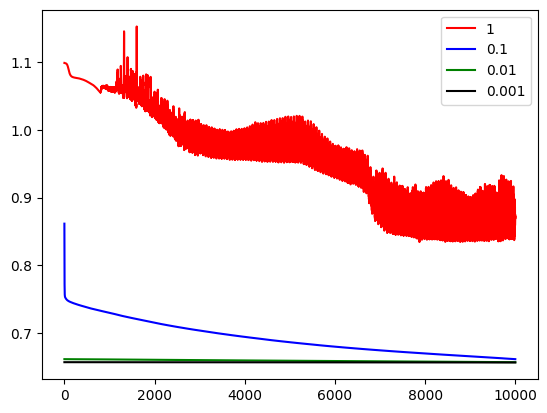

In [13]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list2=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD()
training(X,y)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='red')
#plt.plot(x1,loss_list1)

optimizer = Optimizer_SGD(0.1)
loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='blue')
#plt.plot(x1,loss_list1)

optimizer = Optimizer_SGD(0.01)
loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='green')
#plt.plot(x1,loss_list1)

optimizer = Optimizer_SGD(0.001)
loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='black')

plt.legend(['1','0.1','0.01','0.001'])

In [14]:
# x1=range(epoch+1)
# plt.plot(x1,loss_list1)
# plt.plot(x1,loss_list2,color='red')
# plt.plot(x1,loss_list3,color='green')
# plt.plot(x1,loss_list4,color='m')
# plt.plot()

## SGD with changing learning rate and momentum

epoch: 0, acc: 0.720, loss: 0.657, lr: 0.1
epoch: 5000, acc: 0.740, loss: 0.605, lr: 0.1
epoch: 10000, acc: 0.767, loss: 0.558, lr: 0.1
epoch: 0, acc: 0.767, loss: 0.558, lr: 0.1
epoch: 5000, acc: 0.807, loss: 0.492, lr: 0.1
epoch: 10000, acc: 0.830, loss: 0.450, lr: 0.1
epoch: 0, acc: 0.827, loss: 0.450, lr: 0.1
epoch: 5000, acc: 0.840, loss: 0.415, lr: 0.1
epoch: 10000, acc: 0.840, loss: 0.396, lr: 0.1
epoch: 0, acc: 0.840, loss: 0.398, lr: 0.1
epoch: 5000, acc: 0.850, loss: 0.378, lr: 0.1
epoch: 10000, acc: 0.857, loss: 0.370, lr: 0.1


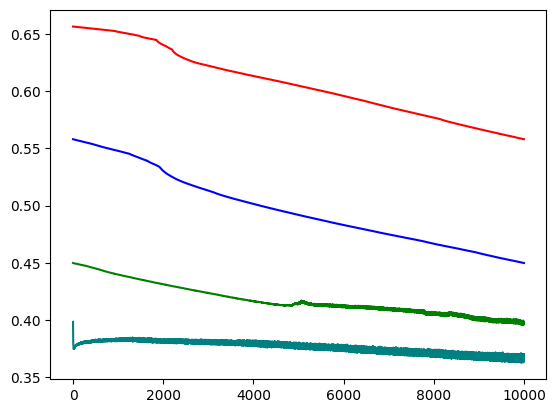

In [15]:
loss_list2=[]
# Create optimizer With Momentomen
optimizer = Optimizer_SGD(learning_rate=0.1,momentum=0.)
training(X,y)

#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='red')
#plt.plot(x1,loss_list1)
optimizer = Optimizer_SGD(learning_rate=0.1, momentum=0.1)

loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='blue')
#plt.plot(x1,loss_list1)

optimizer = Optimizer_SGD(learning_rate=0.1, momentum=0.2)

loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='green')
#plt.plot(x1,loss_list1)

optimizer = Optimizer_SGD(learning_rate=0.1, momentum=0.25)

loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='teal')

## Adagrad with changing learning rate

epoch: 0, acc: 0.343, loss: 1.099, lr: 0.01
epoch: 5000, acc: 0.607, loss: 0.878, lr: 0.01
epoch: 10000, acc: 0.673, loss: 0.766, lr: 0.01
epoch: 0, acc: 0.670, loss: 0.766, lr: 0.1
epoch: 5000, acc: 0.777, loss: 0.616, lr: 0.1
epoch: 10000, acc: 0.813, loss: 0.545, lr: 0.1
epoch: 0, acc: 0.793, loss: 0.545, lr: 0.2
epoch: 5000, acc: 0.820, loss: 0.503, lr: 0.2
epoch: 10000, acc: 0.833, loss: 0.472, lr: 0.2
epoch: 0, acc: 0.810, loss: 0.472, lr: 0.25
epoch: 5000, acc: 0.843, loss: 0.439, lr: 0.25
epoch: 10000, acc: 0.850, loss: 0.410, lr: 0.25


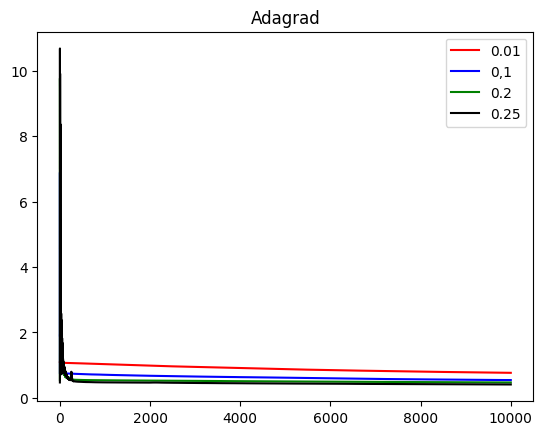

In [16]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list2=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adagrad()
training(X,y)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='red')
#plt.plot(x1,loss_list1)


optimizer = Optimizer_Adagrad(0.1)
loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='blue')
#plt.plot(x1,loss_list1)


optimizer = Optimizer_Adagrad(0.2)
loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='green')
#plt.plot(x1,loss_list1)


optimizer = Optimizer_Adagrad(0.25)
loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='black')

plt.title('Adagrad')
plt.legend(['0.01','0,1','0.2','0.25'])

## RMS with changing learning rate

epoch: 0, acc: 0.320, loss: 1.099, lr: 0.001
epoch: 5000, acc: 0.797, loss: 0.567, lr: 0.001
epoch: 10000, acc: 0.863, loss: 0.403, lr: 0.001
epoch: 0, acc: 0.857, loss: 0.403, lr: 0.01
epoch: 5000, acc: 0.817, loss: 0.443, lr: 0.01
epoch: 10000, acc: 0.900, loss: 0.272, lr: 0.01


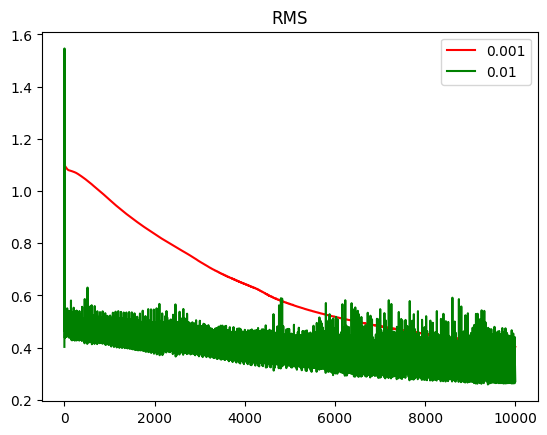

In [17]:
# Driver Code for RMS(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list2=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_RMS()
training(X,y)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='red')
#plt.plot(x1,loss_list1)


optimizer = Optimizer_RMS(0.01)
loss_list2=[]
training(X,y)
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='green')
#plt.plot(x1,loss_list1)




plt.title('RMS')
plt.legend(['0.001','0.01'])

## Adam optimizer with changing learning rate

epoch: 0, acc: 0.887, loss: 0.275, lr: 0.001
epoch: 5000, acc: 0.920, loss: 0.225, lr: 0.001
epoch: 10000, acc: 0.950, loss: 0.157, lr: 0.001
epoch: 0, acc: 0.943, loss: 0.157, lr: 0.0015
epoch: 5000, acc: 0.977, loss: 0.104, lr: 0.0014962600978853356
epoch: 10000, acc: 0.970, loss: 0.086, lr: 0.0014925380559890826


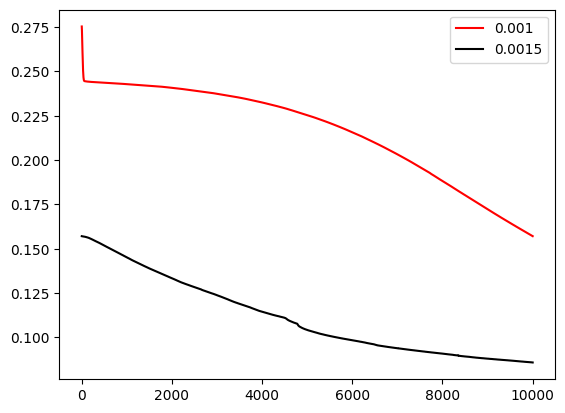

In [18]:
## ADAM

loss_list2=[]
# Create optimizer With Momentomen
#optimizer = Optimizer_Adam(learning_rate=0.001)
optimizer = Optimizer_Adam()
training(X,y)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='red')

loss_list2=[]
# Create optimizer With Momentomen
#optimizer = Optimizer_Adam(learning_rate=0.001)
optimizer = Optimizer_Adam(learning_rate=0.0015, decay=5e-7)
training(X,y)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='black')

plt.legend(['0.001','0.0015'])

## Comparision with all the optimizers

epoch: 0, acc: 0.970, loss: 0.086, lr: 0.001
epoch: 5000, acc: 0.970, loss: 0.086, lr: 0.001
epoch: 10000, acc: 0.970, loss: 0.085, lr: 0.001
epoch: 0, acc: 0.970, loss: 0.085, lr: 0.001
epoch: 5000, acc: 0.970, loss: 0.085, lr: 0.001
epoch: 10000, acc: 0.970, loss: 0.085, lr: 0.001
epoch: 0, acc: 0.970, loss: 0.085, lr: 0.001
epoch: 5000, acc: 0.970, loss: 0.086, lr: 0.001
epoch: 10000, acc: 0.970, loss: 0.085, lr: 0.001
epoch: 0, acc: 0.963, loss: 0.085, lr: 0.001
epoch: 5000, acc: 0.963, loss: 0.084, lr: 0.001
epoch: 10000, acc: 0.963, loss: 0.084, lr: 0.001


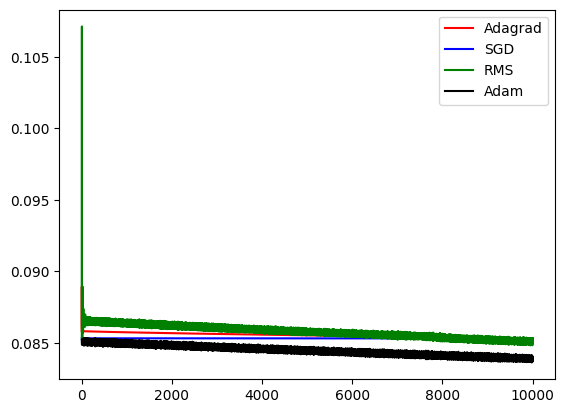

In [19]:
loss_list2=[]
# Create optimizer With Momentomen
optimizer = Optimizer_Adagrad(learning_rate=0.001)
training(X,y)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='red')



loss_list2=[]
# Create optimizer With Momentomen
optimizer = Optimizer_SGD(learning_rate=0.001)
training(X,y)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='blue')



loss_list2=[]
# Create optimizer With Momentomen
optimizer = Optimizer_RMS(learning_rate=0.001)
training(X,y)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='green')




loss_list2=[]
# Create optimizer With Momentomen
training(X,y)
optimizer = Optimizer_Adam(learning_rate=0.001, decay=5e-7)
#training(X,y)
# Train in loop
epoch=10000
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='black')

plt.legend(['Adagrad','SGD' , 'RMS' , 'Adam'])